In [10]:
# from BuildData import BuildData
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

conf = {'lag_day': 3,
        'lag_bin': 3,
        'lag_week': 1,
        'bin_num': 24,
        'file_dir': '../data/0308/'}

# m_data = BuildData(conf= conf).genNewFeatureBinVolume(file_path= '../data/0308/000046_XSHE_25_daily.csv', stock_info= None)

In [2]:
column_names, first_elements = [], []
# 生成节点名称
for i in range(0, 13):
    column_names.append(f'node{i}')

inputs_df = pd.DataFrame(columns= column_names)
# sub_matrix = data.iloc[5: 8, 0: 4]
# row = []
# for i in range(0, 3):
#     row0 = sub_matrix.iloc[i, :].values
#     for j in range(0, 4):
#         row.append(row0[j])
# # print(len(row))
# # row.append()
# node0 = row.pop()
# row.insert(0, node0)
# row.insert(1, data.iloc[0, 3])
# inputs_df.loc[0] = row

lag_bin, lag_day = 3, 3
z = 0
for t in range(7, m_data.shape[0]):
    for m in range(lag_bin, m_data.shape[1]):
        # sub_matrix = m_data.iloc[(t- lag_day): t+1, (m- lag_bin): m+ 1]
        sub_matrix = m_data.iloc[(t- lag_day)+1: t+ 1, (m- lag_bin): m+1]
        row = []
        for i in range(0, lag_day):
            row0 = sub_matrix.iloc[i, :].values
            for j in range(0, lag_bin+ 1):
                row.append(row0[j])
        node0, node1 = row.pop(), m_data.iloc[t-7, m]
        row.insert(0, node0)
        row.insert(1, node1)
        inputs_df.loc[z] = row
        z +=1

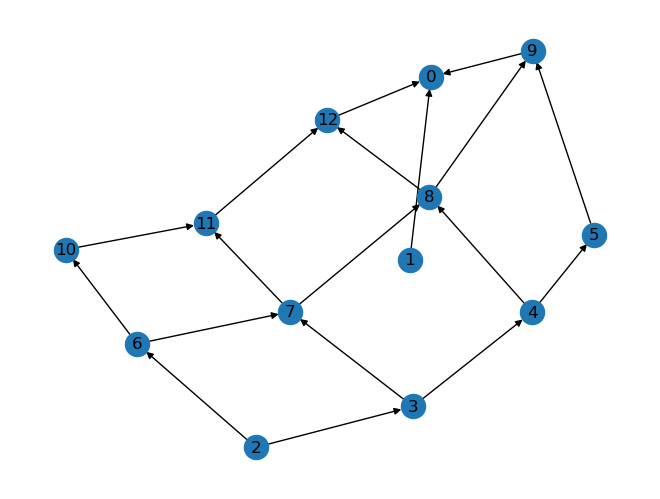

In [8]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

lag_day, lag_bin = 3, 3
connection = [(1, 0), 
              (9, 0), (12, 0), 
              (8, 9), (8, 12), (5, 9), (11, 12), 
              (4, 5), (4, 8), (7, 8), (7, 11), (10, 11), 
              (3, 4), (3, 7), (6, 7), (6, 10), (2, 3), (2, 6)]
adj_matrix = np.zeros((13, 13))
for source, target in connection:
    adj_matrix[source][target] = 1
import networkx as nx
G = nx.DiGraph()
G.add_edges_from(connection)
nx.draw(G, with_labels=True)

In [9]:
df = pd.DataFrame()
lag_day_list, lag_bin_list = [], []
for t in range(-lag_day+1, 1):
    for m in range(-lag_bin, 1):
        lag_day_list.append(t)
        lag_bin_list.append(m)
df['lag_day'] = lag_day_list
df['lag_bin'] = lag_bin_list
station_coords=df[['lag_day','lag_bin']].values
station_coords

array([[-2, -3],
       [-2, -2],
       [-2, -1],
       [-2,  0],
       [-1, -3],
       [-1, -2],
       [-1, -1],
       [-1,  0],
       [ 0, -3],
       [ 0, -2],
       [ 0, -1],
       [ 0,  0]], dtype=int64)

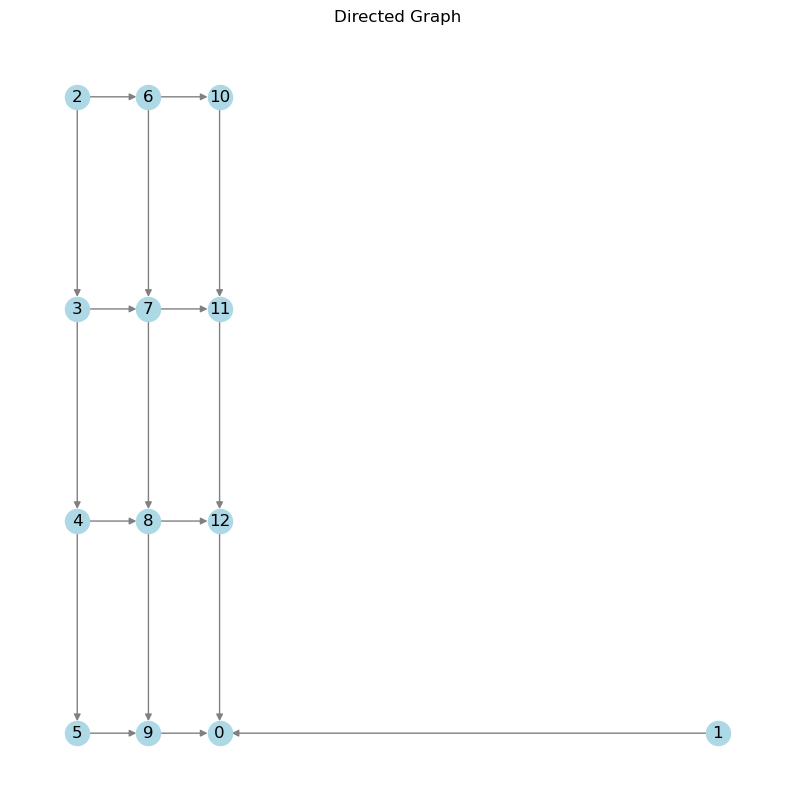

In [10]:
res = {}
for i in range(len(station_coords)):
    res[i+2] = [station_coords[i][0], abs(station_coords[i][1])]
node0, node1 = res.pop(13), [7, 0]
res[0], res[1] = node0, node1
# res[1] = node1
res = dict(sorted(res.items(), key=lambda x: x[1][1], reverse=True))
plt.figure(figsize=(10, 10))
nx.draw_networkx(G, pos= res, with_labels=True, node_color='lightblue', edge_color='gray', arrows= True)
plt.title("Directed Graph")
plt.axis('off')
plt.show()

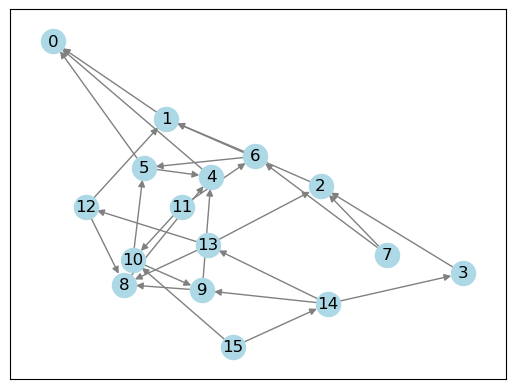

In [3]:
lag_bin, lag_day = 3, 3
import numpy as np
import networkx as nx
matrix_size = (lag_bin +1)*(lag_day + 1) 
adj_matrix = np.zeros((matrix_size, matrix_size))
node0=[]
node1=[]
for i in range(lag_day+1):
    node0.append((lag_bin+1)*i)
for i in range(1, matrix_size):
    if (i not in node0):
        adj_matrix[i, i - 1] = 1
        if i>4: 
            adj_matrix[i, i-(lag_bin+1) - 1] = 1
        else:
            adj_matrix[i-(lag_bin+1) - 1,i] = 1
    else:
        adj_matrix[i, i - 1 - lag_bin] = 1

adjacency = adj_matrix.copy()
G = nx.DiGraph(adjacency)
nx.draw_networkx(G, with_labels=True, node_color='lightblue', edge_color='gray', arrows= True)